# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

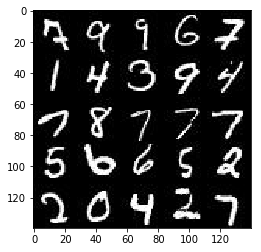

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

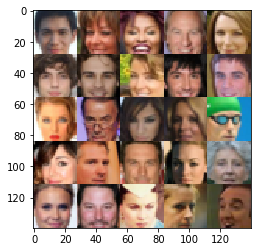

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Helper Method
Each convolution goes throught the same process of batch_normalization and then a leaky relu

In [6]:
def batch_lrelu(x, alpha=0.1, batch_normalization=True, is_train=True):
    if batch_normalization:
        temp = tf.layers.batch_normalization(x, training=is_train)
        return tf.maximum(alpha * x, x)
    else:
        return tf.maximum(alpha * x, x) 

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    kernal_size = 5
    filters = [64, 128, 256, 512]
    with tf.variable_scope('discriminator', reuse=reuse):
        c1 = tf.layers.conv2d(images, filters[0], kernal_size, strides=2, padding='same')
        c1 = batch_lrelu(c1, batch_normalization=False)

        c1 = tf.layers.conv2d(c1, filters[1], kernal_size, strides=2, padding='same')
        c1 = batch_lrelu(c1)

        c1 = tf.layers.conv2d(c1, filters[2], kernal_size, strides=2, padding='same')
        c1 = batch_lrelu(c1)
        
        flat = tf.reshape(c1, [-1, 4 * 4 * filters[2]])
        logits = tf.layers.dense(flat, 1)
        output = tf.tanh(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernal_size = 5
    filters = [512, 256, 128, 64]
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7 * 7 * filters[0])

        c1 = tf.reshape(h1, [-1, 7, 7, filters[0]])
        c1 = tf.layers.conv2d_transpose(c1, filters[1], 5, strides=2, padding='same')
        c1 = batch_lrelu(c1)

        c1 = tf.layers.conv2d_transpose(c1, filters[2], 5, strides=2, padding='same')
        c1 = batch_lrelu(c1)

        logit = tf.layers.conv2d_transpose(c1, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logit)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                      labels=tf.ones_like(d_model_real) * (1 - smooth))) 
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                      labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    g_var = [var for var in t_vars if var.name.startswith('generator')]
    d_var = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_var)
        d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_var)
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_data, z_data, t_lr = model_inputs(image_width, image_height, image_channels, z_dim)   
    disc_loss, gen_loss = model_loss(input_data, z_data, image_channels)
    disc_train, gen_train = model_opt(disc_loss, gen_loss, t_lr, beta1)

    steps = 0
    losses = {'g_loss': [], 'd_loss': []}

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                noise_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_train, feed_dict={input_data: batch_images, z_data: noise_z, t_lr: learning_rate})
                _ = sess.run(gen_train, feed_dict={input_data: batch_images, z_data: noise_z, t_lr: learning_rate})
                
                if not steps % 10:
                    training_loss_d = sess.run(disc_loss, feed_dict={input_data: batch_images, z_data: noise_z})
                    training_loss_g = sess.run(gen_loss, feed_dict={z_data: noise_z})
                    losses['g_loss'].append(training_loss_g)
                    losses['d_loss'].append(training_loss_d)
                    
                    print('Epoch: {} Gen Loss: {:.4f} Disc Loss: {:.4f}'.format(epoch_i, training_loss_g, training_loss_d))
                
                if not steps % 100:
                    show_generator_output(sess, 5 * 5, z_data, image_channels, image_mode=data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 Gen Loss: 0.6399 Disc Loss: 1.0755
Epoch: 0 Gen Loss: 0.7329 Disc Loss: 1.0119
Epoch: 0 Gen Loss: 0.6825 Disc Loss: 1.1455
Epoch: 0 Gen Loss: 1.0876 Disc Loss: 0.7867
Epoch: 0 Gen Loss: 1.1296 Disc Loss: 0.7555
Epoch: 0 Gen Loss: 0.7338 Disc Loss: 0.9882
Epoch: 0 Gen Loss: 0.7816 Disc Loss: 0.9422
Epoch: 0 Gen Loss: 1.0240 Disc Loss: 0.7765
Epoch: 0 Gen Loss: 1.2581 Disc Loss: 0.6628
Epoch: 0 Gen Loss: 1.6433 Disc Loss: 0.5518


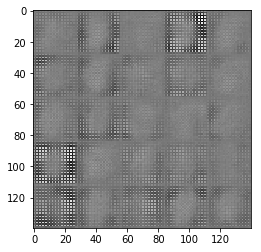

Epoch: 0 Gen Loss: 2.4159 Disc Loss: 0.4481
Epoch: 0 Gen Loss: 3.2765 Disc Loss: 0.3712
Epoch: 0 Gen Loss: 3.4432 Disc Loss: 0.3652
Epoch: 0 Gen Loss: 2.8184 Disc Loss: 0.4318
Epoch: 0 Gen Loss: 1.8945 Disc Loss: 0.6176
Epoch: 0 Gen Loss: 3.7641 Disc Loss: 0.4616
Epoch: 0 Gen Loss: 2.4209 Disc Loss: 1.0547
Epoch: 0 Gen Loss: 2.7398 Disc Loss: 0.6182
Epoch: 0 Gen Loss: 2.4622 Disc Loss: 0.5569
Epoch: 0 Gen Loss: 1.5475 Disc Loss: 0.9775


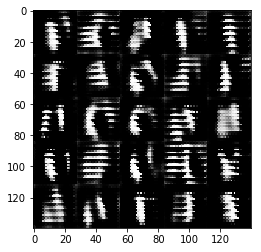

Epoch: 0 Gen Loss: 1.4817 Disc Loss: 1.0709
Epoch: 0 Gen Loss: 1.3370 Disc Loss: 0.9579
Epoch: 0 Gen Loss: 1.7373 Disc Loss: 0.8953
Epoch: 0 Gen Loss: 2.4466 Disc Loss: 0.7593
Epoch: 0 Gen Loss: 1.1234 Disc Loss: 1.5949
Epoch: 0 Gen Loss: 1.1490 Disc Loss: 1.3723
Epoch: 0 Gen Loss: 1.5808 Disc Loss: 0.8452
Epoch: 0 Gen Loss: 1.1954 Disc Loss: 1.0996
Epoch: 0 Gen Loss: 1.4270 Disc Loss: 1.0538
Epoch: 0 Gen Loss: 0.9888 Disc Loss: 1.3145


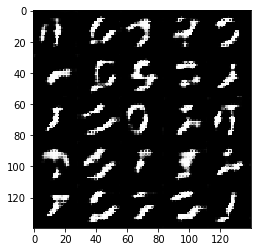

Epoch: 0 Gen Loss: 1.2678 Disc Loss: 1.3982
Epoch: 0 Gen Loss: 1.1508 Disc Loss: 1.5441
Epoch: 0 Gen Loss: 1.2675 Disc Loss: 1.1967
Epoch: 0 Gen Loss: 1.0621 Disc Loss: 1.1601
Epoch: 0 Gen Loss: 1.2339 Disc Loss: 1.0098
Epoch: 0 Gen Loss: 1.2814 Disc Loss: 1.0131
Epoch: 0 Gen Loss: 1.3891 Disc Loss: 0.9470
Epoch: 0 Gen Loss: 1.1886 Disc Loss: 0.9883
Epoch: 0 Gen Loss: 1.0792 Disc Loss: 1.2172
Epoch: 0 Gen Loss: 1.0811 Disc Loss: 1.4000


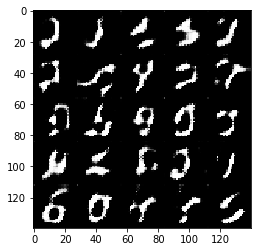

Epoch: 0 Gen Loss: 0.9309 Disc Loss: 1.4922
Epoch: 0 Gen Loss: 1.2463 Disc Loss: 1.0398
Epoch: 0 Gen Loss: 1.2903 Disc Loss: 1.0002
Epoch: 0 Gen Loss: 1.3531 Disc Loss: 1.0170
Epoch: 0 Gen Loss: 1.1204 Disc Loss: 1.0816
Epoch: 0 Gen Loss: 0.9328 Disc Loss: 1.4039
Epoch: 0 Gen Loss: 1.0895 Disc Loss: 1.3403
Epoch: 0 Gen Loss: 1.1362 Disc Loss: 1.3501
Epoch: 0 Gen Loss: 1.1302 Disc Loss: 1.1461
Epoch: 0 Gen Loss: 1.1242 Disc Loss: 1.2229


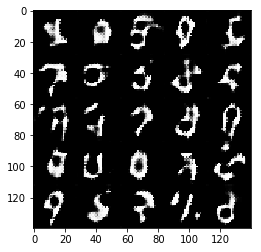

Epoch: 0 Gen Loss: 1.2515 Disc Loss: 1.0394
Epoch: 0 Gen Loss: 1.0867 Disc Loss: 1.1134
Epoch: 0 Gen Loss: 1.2266 Disc Loss: 1.0965
Epoch: 0 Gen Loss: 1.0247 Disc Loss: 1.2303
Epoch: 0 Gen Loss: 0.9583 Disc Loss: 1.2717
Epoch: 0 Gen Loss: 0.9636 Disc Loss: 1.2355
Epoch: 0 Gen Loss: 1.0894 Disc Loss: 1.1674
Epoch: 0 Gen Loss: 1.2023 Disc Loss: 1.0243
Epoch: 0 Gen Loss: 1.2251 Disc Loss: 1.2260
Epoch: 0 Gen Loss: 1.1799 Disc Loss: 1.0354


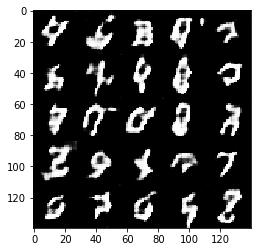

Epoch: 0 Gen Loss: 1.0045 Disc Loss: 1.2902
Epoch: 0 Gen Loss: 1.1299 Disc Loss: 1.1655
Epoch: 0 Gen Loss: 0.8594 Disc Loss: 1.3556
Epoch: 0 Gen Loss: 0.9762 Disc Loss: 1.3092
Epoch: 0 Gen Loss: 1.3516 Disc Loss: 0.9900
Epoch: 0 Gen Loss: 1.1619 Disc Loss: 1.1620
Epoch: 0 Gen Loss: 0.8165 Disc Loss: 1.3305
Epoch: 0 Gen Loss: 1.2156 Disc Loss: 1.0674
Epoch: 0 Gen Loss: 1.3628 Disc Loss: 0.9080
Epoch: 0 Gen Loss: 1.5332 Disc Loss: 0.8581


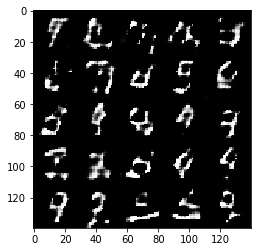

Epoch: 0 Gen Loss: 0.7591 Disc Loss: 1.7171
Epoch: 0 Gen Loss: 0.9456 Disc Loss: 1.2275
Epoch: 0 Gen Loss: 0.8532 Disc Loss: 1.4632
Epoch: 0 Gen Loss: 1.3260 Disc Loss: 0.9292
Epoch: 0 Gen Loss: 1.4282 Disc Loss: 0.9708
Epoch: 0 Gen Loss: 0.9017 Disc Loss: 1.3063
Epoch: 0 Gen Loss: 0.9544 Disc Loss: 1.2197
Epoch: 0 Gen Loss: 0.9790 Disc Loss: 1.3495
Epoch: 0 Gen Loss: 1.0616 Disc Loss: 1.2580
Epoch: 0 Gen Loss: 1.2428 Disc Loss: 1.0987


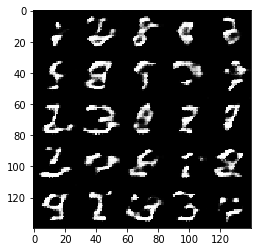

Epoch: 0 Gen Loss: 0.9929 Disc Loss: 1.3217
Epoch: 0 Gen Loss: 1.1035 Disc Loss: 1.1421
Epoch: 0 Gen Loss: 1.3278 Disc Loss: 1.1185
Epoch: 0 Gen Loss: 1.0123 Disc Loss: 1.4021
Epoch: 0 Gen Loss: 1.3674 Disc Loss: 0.9354
Epoch: 0 Gen Loss: 1.2367 Disc Loss: 1.3002
Epoch: 0 Gen Loss: 1.0511 Disc Loss: 1.2066
Epoch: 0 Gen Loss: 0.9802 Disc Loss: 1.2270
Epoch: 0 Gen Loss: 0.8625 Disc Loss: 1.3617
Epoch: 0 Gen Loss: 1.4185 Disc Loss: 0.9823


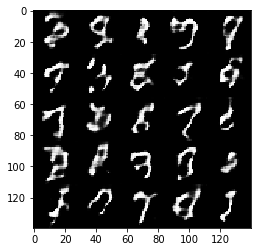

Epoch: 0 Gen Loss: 1.0134 Disc Loss: 1.2551
Epoch: 0 Gen Loss: 1.1359 Disc Loss: 1.0457
Epoch: 0 Gen Loss: 1.0357 Disc Loss: 1.1434
Epoch: 1 Gen Loss: 0.8581 Disc Loss: 1.3907
Epoch: 1 Gen Loss: 1.0652 Disc Loss: 1.2698
Epoch: 1 Gen Loss: 1.3386 Disc Loss: 1.1625
Epoch: 1 Gen Loss: 1.0255 Disc Loss: 1.1955
Epoch: 1 Gen Loss: 1.3096 Disc Loss: 0.9779
Epoch: 1 Gen Loss: 0.9619 Disc Loss: 1.5692
Epoch: 1 Gen Loss: 0.8295 Disc Loss: 1.4570


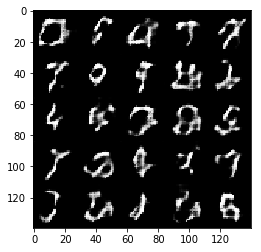

Epoch: 1 Gen Loss: 1.0891 Disc Loss: 1.1247
Epoch: 1 Gen Loss: 0.7918 Disc Loss: 1.5300
Epoch: 1 Gen Loss: 0.9823 Disc Loss: 1.2134
Epoch: 1 Gen Loss: 1.1255 Disc Loss: 1.1301
Epoch: 1 Gen Loss: 0.9585 Disc Loss: 1.4394
Epoch: 1 Gen Loss: 1.1636 Disc Loss: 1.0726
Epoch: 1 Gen Loss: 1.1777 Disc Loss: 1.0970
Epoch: 1 Gen Loss: 0.8405 Disc Loss: 1.3902
Epoch: 1 Gen Loss: 1.0164 Disc Loss: 1.1797
Epoch: 1 Gen Loss: 1.0165 Disc Loss: 1.3374


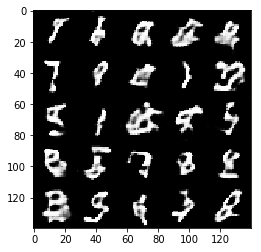

Epoch: 1 Gen Loss: 0.8321 Disc Loss: 1.4628
Epoch: 1 Gen Loss: 1.0508 Disc Loss: 1.2333
Epoch: 1 Gen Loss: 1.0914 Disc Loss: 1.1361
Epoch: 1 Gen Loss: 0.9943 Disc Loss: 1.2149
Epoch: 1 Gen Loss: 0.9643 Disc Loss: 1.2587
Epoch: 1 Gen Loss: 1.0974 Disc Loss: 1.2082
Epoch: 1 Gen Loss: 0.8901 Disc Loss: 1.3841
Epoch: 1 Gen Loss: 0.8511 Disc Loss: 1.3547
Epoch: 1 Gen Loss: 0.8275 Disc Loss: 1.2889
Epoch: 1 Gen Loss: 0.8422 Disc Loss: 1.3253


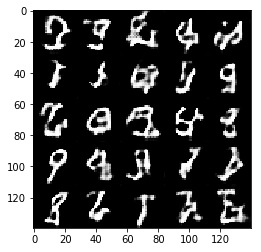

Epoch: 1 Gen Loss: 0.9269 Disc Loss: 1.1862
Epoch: 1 Gen Loss: 0.9973 Disc Loss: 1.2094
Epoch: 1 Gen Loss: 0.9707 Disc Loss: 1.3811
Epoch: 1 Gen Loss: 1.1587 Disc Loss: 1.2646
Epoch: 1 Gen Loss: 0.9682 Disc Loss: 1.2832
Epoch: 1 Gen Loss: 1.1375 Disc Loss: 1.0484
Epoch: 1 Gen Loss: 1.1187 Disc Loss: 1.0934
Epoch: 1 Gen Loss: 0.7597 Disc Loss: 1.3864
Epoch: 1 Gen Loss: 0.9634 Disc Loss: 1.1845
Epoch: 1 Gen Loss: 1.1227 Disc Loss: 1.1029


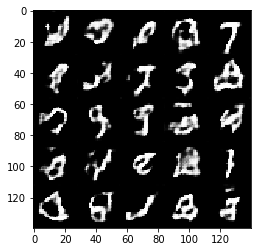

Epoch: 1 Gen Loss: 1.0420 Disc Loss: 1.1548
Epoch: 1 Gen Loss: 0.9509 Disc Loss: 1.2737
Epoch: 1 Gen Loss: 0.9060 Disc Loss: 1.2979
Epoch: 1 Gen Loss: 1.1251 Disc Loss: 1.0950
Epoch: 1 Gen Loss: 0.9431 Disc Loss: 1.2684
Epoch: 1 Gen Loss: 0.9751 Disc Loss: 1.3820
Epoch: 1 Gen Loss: 1.0284 Disc Loss: 1.3090
Epoch: 1 Gen Loss: 0.9882 Disc Loss: 1.2350
Epoch: 1 Gen Loss: 1.0128 Disc Loss: 1.2121
Epoch: 1 Gen Loss: 1.1624 Disc Loss: 1.1926


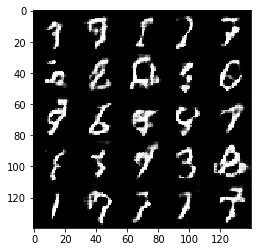

Epoch: 1 Gen Loss: 0.8484 Disc Loss: 1.4053
Epoch: 1 Gen Loss: 1.0194 Disc Loss: 1.1621
Epoch: 1 Gen Loss: 1.0223 Disc Loss: 1.1893
Epoch: 1 Gen Loss: 1.1935 Disc Loss: 1.2631
Epoch: 1 Gen Loss: 1.3430 Disc Loss: 1.1689
Epoch: 1 Gen Loss: 0.8985 Disc Loss: 1.3137
Epoch: 1 Gen Loss: 0.9538 Disc Loss: 1.2110
Epoch: 1 Gen Loss: 0.9292 Disc Loss: 1.2887
Epoch: 1 Gen Loss: 1.0561 Disc Loss: 1.0815
Epoch: 1 Gen Loss: 0.8878 Disc Loss: 1.2342


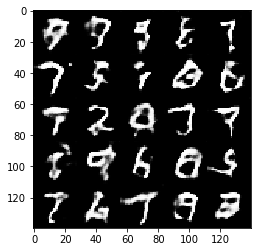

Epoch: 1 Gen Loss: 0.8681 Disc Loss: 1.2341
Epoch: 1 Gen Loss: 1.1185 Disc Loss: 1.0684
Epoch: 1 Gen Loss: 1.1242 Disc Loss: 1.2074
Epoch: 1 Gen Loss: 0.8024 Disc Loss: 1.3125
Epoch: 1 Gen Loss: 0.9923 Disc Loss: 1.2333
Epoch: 1 Gen Loss: 1.1096 Disc Loss: 1.0998
Epoch: 1 Gen Loss: 1.0635 Disc Loss: 1.2603
Epoch: 1 Gen Loss: 0.9221 Disc Loss: 1.3367
Epoch: 1 Gen Loss: 1.0207 Disc Loss: 1.2422
Epoch: 1 Gen Loss: 1.1437 Disc Loss: 1.0611


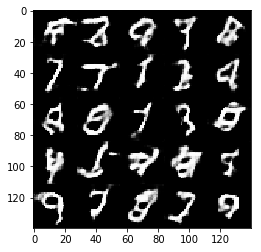

Epoch: 1 Gen Loss: 0.8434 Disc Loss: 1.2644
Epoch: 1 Gen Loss: 0.9474 Disc Loss: 1.2161
Epoch: 1 Gen Loss: 1.0492 Disc Loss: 1.2993
Epoch: 1 Gen Loss: 1.0012 Disc Loss: 1.1938
Epoch: 1 Gen Loss: 0.9507 Disc Loss: 1.3014
Epoch: 1 Gen Loss: 1.1000 Disc Loss: 1.2131
Epoch: 1 Gen Loss: 1.2367 Disc Loss: 1.1579
Epoch: 1 Gen Loss: 1.0208 Disc Loss: 1.1895
Epoch: 1 Gen Loss: 0.9732 Disc Loss: 1.3288
Epoch: 1 Gen Loss: 0.8147 Disc Loss: 1.3780


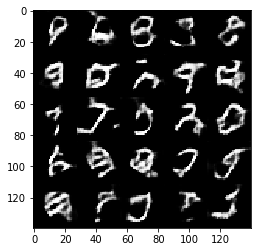

Epoch: 1 Gen Loss: 1.0026 Disc Loss: 1.1138
Epoch: 1 Gen Loss: 0.9091 Disc Loss: 1.2618
Epoch: 1 Gen Loss: 1.2033 Disc Loss: 1.0773
Epoch: 1 Gen Loss: 1.1389 Disc Loss: 1.2496
Epoch: 1 Gen Loss: 1.0165 Disc Loss: 1.2788
Epoch: 1 Gen Loss: 1.1630 Disc Loss: 1.1290
Epoch: 1 Gen Loss: 1.0026 Disc Loss: 1.2239
Epoch: 1 Gen Loss: 1.0630 Disc Loss: 1.0924
Epoch: 1 Gen Loss: 1.1583 Disc Loss: 1.1674
Epoch: 1 Gen Loss: 1.0605 Disc Loss: 1.3234


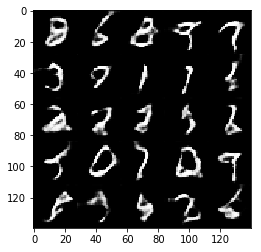

Epoch: 1 Gen Loss: 1.3260 Disc Loss: 1.0575
Epoch: 1 Gen Loss: 0.8937 Disc Loss: 1.4263
Epoch: 1 Gen Loss: 0.9221 Disc Loss: 1.3134
Epoch: 1 Gen Loss: 1.0388 Disc Loss: 1.1874
Epoch: 1 Gen Loss: 1.1590 Disc Loss: 1.2472
Epoch: 1 Gen Loss: 1.2611 Disc Loss: 1.0065
Epoch: 1 Gen Loss: 1.0655 Disc Loss: 1.1440
Epoch: 2 Gen Loss: 0.8639 Disc Loss: 1.4162
Epoch: 2 Gen Loss: 0.9886 Disc Loss: 1.2569
Epoch: 2 Gen Loss: 0.9242 Disc Loss: 1.3185


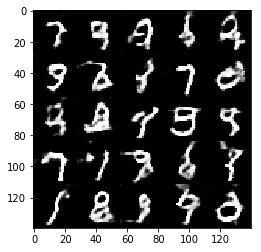

Epoch: 2 Gen Loss: 0.9488 Disc Loss: 1.3232
Epoch: 2 Gen Loss: 1.1872 Disc Loss: 1.0689
Epoch: 2 Gen Loss: 0.8613 Disc Loss: 1.3414
Epoch: 2 Gen Loss: 0.9381 Disc Loss: 1.2293
Epoch: 2 Gen Loss: 1.1615 Disc Loss: 1.1597
Epoch: 2 Gen Loss: 1.0631 Disc Loss: 1.2523
Epoch: 2 Gen Loss: 1.1159 Disc Loss: 1.2234
Epoch: 2 Gen Loss: 1.1058 Disc Loss: 1.1750
Epoch: 2 Gen Loss: 0.7614 Disc Loss: 1.5097
Epoch: 2 Gen Loss: 0.9306 Disc Loss: 1.2937


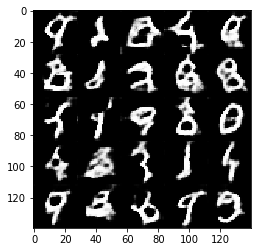

Epoch: 2 Gen Loss: 1.1842 Disc Loss: 1.1855
Epoch: 2 Gen Loss: 0.8897 Disc Loss: 1.3473
Epoch: 2 Gen Loss: 1.1798 Disc Loss: 1.0438
Epoch: 2 Gen Loss: 1.0493 Disc Loss: 1.3402
Epoch: 2 Gen Loss: 0.9394 Disc Loss: 1.2608
Epoch: 2 Gen Loss: 1.0931 Disc Loss: 1.1502
Epoch: 2 Gen Loss: 0.9286 Disc Loss: 1.3503
Epoch: 2 Gen Loss: 0.9156 Disc Loss: 1.3402
Epoch: 2 Gen Loss: 1.2092 Disc Loss: 1.0766
Epoch: 2 Gen Loss: 0.9035 Disc Loss: 1.3877


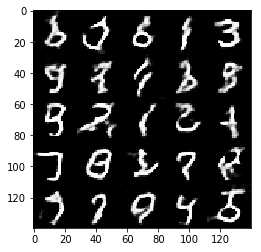

Epoch: 2 Gen Loss: 0.8807 Disc Loss: 1.3394
Epoch: 2 Gen Loss: 1.1361 Disc Loss: 1.0837
Epoch: 2 Gen Loss: 0.9742 Disc Loss: 1.2636
Epoch: 2 Gen Loss: 0.9536 Disc Loss: 1.3900
Epoch: 2 Gen Loss: 1.0135 Disc Loss: 1.2009
Epoch: 2 Gen Loss: 1.0197 Disc Loss: 1.1624
Epoch: 2 Gen Loss: 0.9992 Disc Loss: 1.3741
Epoch: 2 Gen Loss: 1.0567 Disc Loss: 1.1724
Epoch: 2 Gen Loss: 1.1456 Disc Loss: 1.0377
Epoch: 2 Gen Loss: 0.9890 Disc Loss: 1.2653


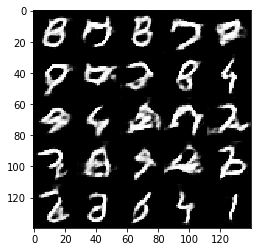

Epoch: 2 Gen Loss: 0.8644 Disc Loss: 1.3938
Epoch: 2 Gen Loss: 1.0742 Disc Loss: 1.0627
Epoch: 2 Gen Loss: 1.0295 Disc Loss: 1.2056
Epoch: 2 Gen Loss: 0.9429 Disc Loss: 1.3099
Epoch: 2 Gen Loss: 1.1353 Disc Loss: 1.1021
Epoch: 2 Gen Loss: 1.1080 Disc Loss: 1.1496
Epoch: 2 Gen Loss: 0.9270 Disc Loss: 1.4530
Epoch: 2 Gen Loss: 0.9921 Disc Loss: 1.1592
Epoch: 2 Gen Loss: 1.2364 Disc Loss: 1.1055
Epoch: 2 Gen Loss: 0.8960 Disc Loss: 1.3384


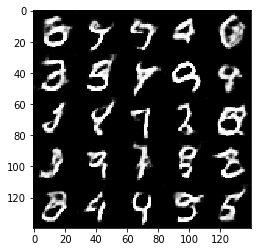

Epoch: 2 Gen Loss: 0.8075 Disc Loss: 1.3480
Epoch: 2 Gen Loss: 1.0473 Disc Loss: 1.1440
Epoch: 2 Gen Loss: 1.0768 Disc Loss: 1.1636
Epoch: 2 Gen Loss: 1.1014 Disc Loss: 1.2003
Epoch: 2 Gen Loss: 1.0479 Disc Loss: 1.1024
Epoch: 2 Gen Loss: 0.8966 Disc Loss: 1.2004
Epoch: 2 Gen Loss: 0.8634 Disc Loss: 1.3985
Epoch: 2 Gen Loss: 0.9187 Disc Loss: 1.2639
Epoch: 2 Gen Loss: 1.0599 Disc Loss: 1.1803
Epoch: 2 Gen Loss: 1.0009 Disc Loss: 1.2760


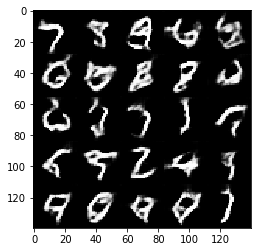

Epoch: 2 Gen Loss: 0.7952 Disc Loss: 1.3305
Epoch: 2 Gen Loss: 1.1048 Disc Loss: 1.1039
Epoch: 2 Gen Loss: 0.9467 Disc Loss: 1.1673
Epoch: 2 Gen Loss: 0.9699 Disc Loss: 1.2983
Epoch: 2 Gen Loss: 1.0322 Disc Loss: 1.1788
Epoch: 2 Gen Loss: 1.0442 Disc Loss: 1.1535
Epoch: 2 Gen Loss: 0.9163 Disc Loss: 1.2668
Epoch: 2 Gen Loss: 1.0027 Disc Loss: 1.1482
Epoch: 2 Gen Loss: 0.9562 Disc Loss: 1.1947
Epoch: 2 Gen Loss: 0.9548 Disc Loss: 1.2255


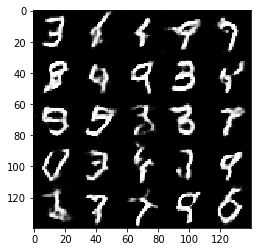

Epoch: 2 Gen Loss: 0.9940 Disc Loss: 1.1689
Epoch: 2 Gen Loss: 1.0071 Disc Loss: 1.1637
Epoch: 2 Gen Loss: 1.0228 Disc Loss: 1.2093
Epoch: 2 Gen Loss: 0.9292 Disc Loss: 1.1998
Epoch: 2 Gen Loss: 1.0857 Disc Loss: 1.1157
Epoch: 2 Gen Loss: 0.9301 Disc Loss: 1.2961
Epoch: 2 Gen Loss: 0.9145 Disc Loss: 1.2151
Epoch: 2 Gen Loss: 1.0906 Disc Loss: 1.0788
Epoch: 2 Gen Loss: 0.9052 Disc Loss: 1.3180
Epoch: 2 Gen Loss: 1.1123 Disc Loss: 1.1010


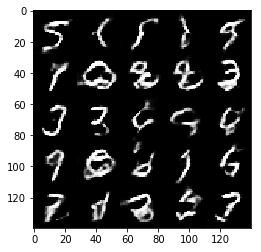

Epoch: 2 Gen Loss: 1.2118 Disc Loss: 1.1686
Epoch: 2 Gen Loss: 1.0168 Disc Loss: 1.2533
Epoch: 2 Gen Loss: 1.0533 Disc Loss: 1.1847
Epoch: 2 Gen Loss: 0.9782 Disc Loss: 1.2023
Epoch: 2 Gen Loss: 0.8955 Disc Loss: 1.3395
Epoch: 2 Gen Loss: 1.0452 Disc Loss: 1.1730
Epoch: 2 Gen Loss: 1.1223 Disc Loss: 1.1550
Epoch: 2 Gen Loss: 1.0957 Disc Loss: 1.2186
Epoch: 2 Gen Loss: 1.3064 Disc Loss: 0.9884
Epoch: 2 Gen Loss: 1.0597 Disc Loss: 1.2694


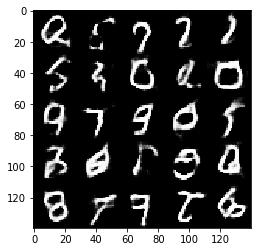

Epoch: 2 Gen Loss: 0.8894 Disc Loss: 1.2011
Epoch: 2 Gen Loss: 1.1316 Disc Loss: 1.0456
Epoch: 2 Gen Loss: 1.0652 Disc Loss: 1.2282
Epoch: 2 Gen Loss: 1.0555 Disc Loss: 1.2044
Epoch: 2 Gen Loss: 1.1527 Disc Loss: 1.1242
Epoch: 2 Gen Loss: 0.8456 Disc Loss: 1.3080
Epoch: 2 Gen Loss: 1.0708 Disc Loss: 1.1090
Epoch: 2 Gen Loss: 1.1931 Disc Loss: 1.1762
Epoch: 2 Gen Loss: 1.0401 Disc Loss: 1.1383
Epoch: 2 Gen Loss: 1.1645 Disc Loss: 1.1296


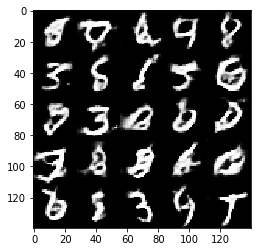

Epoch: 2 Gen Loss: 0.9590 Disc Loss: 1.3122


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3
losses = {}
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Plots
View of how the generator and discriminator losses change with the batches

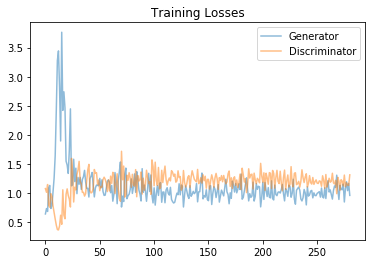

In [16]:
pyplot.plot(losses['g_loss'], label='Generator', alpha=0.5)
pyplot.plot(losses['d_loss'], label='Discriminator', alpha=0.5)
pyplot.title('Training Losses')
pyplot.legend()
pyplot.show()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 Gen Loss: 0.5650 Disc Loss: 1.1934
Epoch: 0 Gen Loss: 0.8289 Disc Loss: 0.9436
Epoch: 0 Gen Loss: 0.7831 Disc Loss: 1.0177
Epoch: 0 Gen Loss: 0.9790 Disc Loss: 0.9056
Epoch: 0 Gen Loss: 0.7889 Disc Loss: 0.9481
Epoch: 0 Gen Loss: 0.8323 Disc Loss: 0.9121
Epoch: 0 Gen Loss: 0.8220 Disc Loss: 0.9238
Epoch: 0 Gen Loss: 1.6043 Disc Loss: 0.5808
Epoch: 0 Gen Loss: 1.4668 Disc Loss: 0.6175
Epoch: 0 Gen Loss: 1.3918 Disc Loss: 0.7301


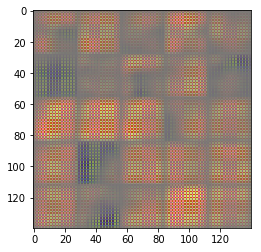

Epoch: 0 Gen Loss: 3.4535 Disc Loss: 0.5105
Epoch: 0 Gen Loss: 1.4305 Disc Loss: 0.8723
Epoch: 0 Gen Loss: 1.6600 Disc Loss: 0.9217
Epoch: 0 Gen Loss: 1.2114 Disc Loss: 1.3144
Epoch: 0 Gen Loss: 1.1769 Disc Loss: 1.1142
Epoch: 0 Gen Loss: 1.5279 Disc Loss: 0.8288
Epoch: 0 Gen Loss: 1.1606 Disc Loss: 0.9991
Epoch: 0 Gen Loss: 1.4017 Disc Loss: 0.7731
Epoch: 0 Gen Loss: 1.0335 Disc Loss: 1.0968
Epoch: 0 Gen Loss: 1.3134 Disc Loss: 0.7826


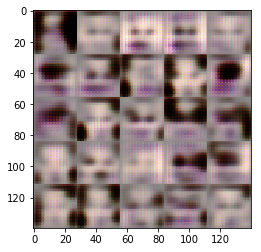

Epoch: 0 Gen Loss: 1.2704 Disc Loss: 0.9400
Epoch: 0 Gen Loss: 1.2700 Disc Loss: 1.0157
Epoch: 0 Gen Loss: 0.8858 Disc Loss: 1.3519
Epoch: 0 Gen Loss: 1.4589 Disc Loss: 0.9513
Epoch: 0 Gen Loss: 0.9716 Disc Loss: 1.5075
Epoch: 0 Gen Loss: 1.2366 Disc Loss: 1.1726
Epoch: 0 Gen Loss: 1.5512 Disc Loss: 1.0396
Epoch: 0 Gen Loss: 1.6120 Disc Loss: 0.9116
Epoch: 0 Gen Loss: 1.3189 Disc Loss: 1.0807
Epoch: 0 Gen Loss: 1.1393 Disc Loss: 0.9743


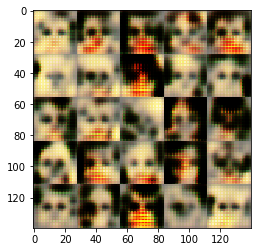

Epoch: 0 Gen Loss: 1.0757 Disc Loss: 1.0907
Epoch: 0 Gen Loss: 1.3348 Disc Loss: 1.2926
Epoch: 0 Gen Loss: 1.6486 Disc Loss: 0.9072
Epoch: 0 Gen Loss: 2.0296 Disc Loss: 0.8699
Epoch: 0 Gen Loss: 0.9122 Disc Loss: 1.4593
Epoch: 0 Gen Loss: 1.4331 Disc Loss: 1.1598
Epoch: 0 Gen Loss: 1.8095 Disc Loss: 0.7996
Epoch: 0 Gen Loss: 1.4991 Disc Loss: 1.2005
Epoch: 0 Gen Loss: 1.0259 Disc Loss: 1.2989
Epoch: 0 Gen Loss: 1.2849 Disc Loss: 1.0526


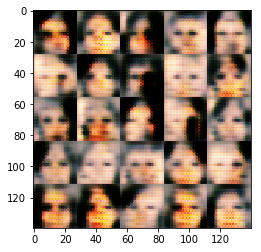

Epoch: 0 Gen Loss: 1.5524 Disc Loss: 0.9026
Epoch: 0 Gen Loss: 1.4793 Disc Loss: 0.9095
Epoch: 0 Gen Loss: 1.3639 Disc Loss: 1.0069
Epoch: 0 Gen Loss: 1.1404 Disc Loss: 1.1164
Epoch: 0 Gen Loss: 1.1784 Disc Loss: 1.1480
Epoch: 0 Gen Loss: 1.4840 Disc Loss: 0.9539
Epoch: 0 Gen Loss: 1.0722 Disc Loss: 1.3823
Epoch: 0 Gen Loss: 0.9094 Disc Loss: 1.2646
Epoch: 0 Gen Loss: 1.0799 Disc Loss: 1.1505
Epoch: 0 Gen Loss: 1.2058 Disc Loss: 1.0164


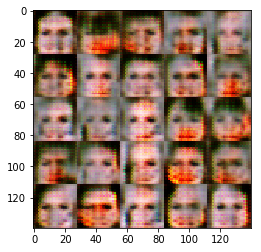

Epoch: 0 Gen Loss: 0.9583 Disc Loss: 1.2205
Epoch: 0 Gen Loss: 1.1856 Disc Loss: 1.1489
Epoch: 0 Gen Loss: 1.0912 Disc Loss: 1.2418
Epoch: 0 Gen Loss: 0.9371 Disc Loss: 1.4230
Epoch: 0 Gen Loss: 1.1152 Disc Loss: 1.3908
Epoch: 0 Gen Loss: 1.0035 Disc Loss: 1.2453
Epoch: 0 Gen Loss: 1.1122 Disc Loss: 1.0930
Epoch: 0 Gen Loss: 1.2065 Disc Loss: 1.1039
Epoch: 0 Gen Loss: 1.0689 Disc Loss: 1.2991
Epoch: 0 Gen Loss: 1.1951 Disc Loss: 1.2792


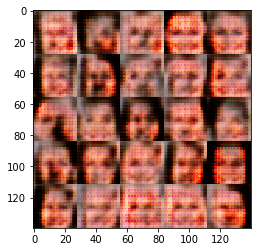

Epoch: 0 Gen Loss: 1.1397 Disc Loss: 1.3396
Epoch: 0 Gen Loss: 0.9917 Disc Loss: 1.4091
Epoch: 0 Gen Loss: 1.3647 Disc Loss: 1.1329
Epoch: 0 Gen Loss: 1.0646 Disc Loss: 1.0711
Epoch: 0 Gen Loss: 1.3045 Disc Loss: 0.9211
Epoch: 0 Gen Loss: 1.1181 Disc Loss: 1.2240
Epoch: 0 Gen Loss: 0.8872 Disc Loss: 1.4620
Epoch: 0 Gen Loss: 1.0883 Disc Loss: 1.2001
Epoch: 0 Gen Loss: 1.0052 Disc Loss: 1.1850
Epoch: 0 Gen Loss: 0.7809 Disc Loss: 1.3373


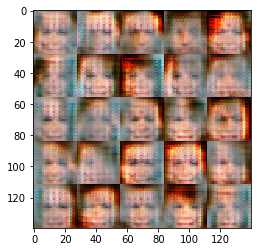

Epoch: 0 Gen Loss: 1.0197 Disc Loss: 1.0915
Epoch: 0 Gen Loss: 1.3166 Disc Loss: 0.9355
Epoch: 0 Gen Loss: 1.1396 Disc Loss: 1.2838
Epoch: 0 Gen Loss: 0.9977 Disc Loss: 1.3309
Epoch: 0 Gen Loss: 1.1417 Disc Loss: 1.2616
Epoch: 0 Gen Loss: 0.9636 Disc Loss: 1.3264
Epoch: 0 Gen Loss: 1.2730 Disc Loss: 1.0449
Epoch: 0 Gen Loss: 1.2890 Disc Loss: 1.0883
Epoch: 0 Gen Loss: 0.8271 Disc Loss: 1.4405
Epoch: 0 Gen Loss: 1.1520 Disc Loss: 1.1751


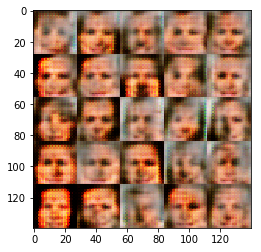

Epoch: 0 Gen Loss: 1.1608 Disc Loss: 1.1696
Epoch: 0 Gen Loss: 0.7940 Disc Loss: 1.4443
Epoch: 0 Gen Loss: 0.9021 Disc Loss: 1.2332
Epoch: 0 Gen Loss: 1.2917 Disc Loss: 1.0039
Epoch: 0 Gen Loss: 1.2262 Disc Loss: 1.0739
Epoch: 0 Gen Loss: 0.9378 Disc Loss: 1.4133
Epoch: 0 Gen Loss: 1.1691 Disc Loss: 1.1570
Epoch: 0 Gen Loss: 0.9997 Disc Loss: 1.3741
Epoch: 0 Gen Loss: 0.8007 Disc Loss: 1.4589
Epoch: 0 Gen Loss: 1.0282 Disc Loss: 1.0388


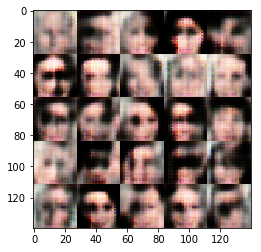

Epoch: 0 Gen Loss: 1.1964 Disc Loss: 1.0339
Epoch: 0 Gen Loss: 0.8748 Disc Loss: 1.6387
Epoch: 0 Gen Loss: 0.9685 Disc Loss: 1.3232
Epoch: 0 Gen Loss: 1.2194 Disc Loss: 1.0419
Epoch: 0 Gen Loss: 0.9027 Disc Loss: 1.4099
Epoch: 0 Gen Loss: 1.0690 Disc Loss: 1.0490
Epoch: 0 Gen Loss: 1.1831 Disc Loss: 0.9903
Epoch: 0 Gen Loss: 0.8892 Disc Loss: 1.4504
Epoch: 0 Gen Loss: 0.9373 Disc Loss: 1.2410
Epoch: 0 Gen Loss: 1.1372 Disc Loss: 1.1098


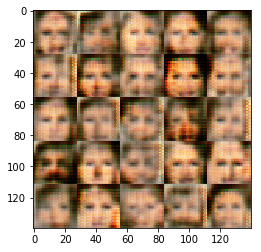

Epoch: 0 Gen Loss: 1.0418 Disc Loss: 1.2635
Epoch: 0 Gen Loss: 0.8920 Disc Loss: 1.2778
Epoch: 0 Gen Loss: 1.4210 Disc Loss: 0.9431
Epoch: 0 Gen Loss: 1.0382 Disc Loss: 1.3116
Epoch: 0 Gen Loss: 1.0589 Disc Loss: 1.4950
Epoch: 0 Gen Loss: 1.2906 Disc Loss: 1.1759
Epoch: 0 Gen Loss: 0.9998 Disc Loss: 1.3058
Epoch: 0 Gen Loss: 1.1132 Disc Loss: 1.1464
Epoch: 0 Gen Loss: 1.1990 Disc Loss: 1.0923
Epoch: 0 Gen Loss: 1.1113 Disc Loss: 1.2446


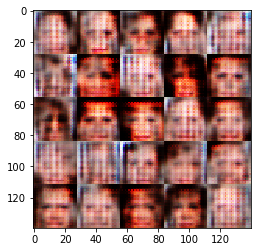

Epoch: 0 Gen Loss: 1.3109 Disc Loss: 1.0719
Epoch: 0 Gen Loss: 1.3555 Disc Loss: 0.9124
Epoch: 0 Gen Loss: 0.8837 Disc Loss: 1.4452
Epoch: 0 Gen Loss: 0.9262 Disc Loss: 1.4456
Epoch: 0 Gen Loss: 1.0548 Disc Loss: 1.1033
Epoch: 0 Gen Loss: 0.9611 Disc Loss: 1.2072
Epoch: 0 Gen Loss: 1.0039 Disc Loss: 1.1912
Epoch: 0 Gen Loss: 1.1483 Disc Loss: 1.0580
Epoch: 0 Gen Loss: 1.0100 Disc Loss: 1.2589
Epoch: 0 Gen Loss: 1.0410 Disc Loss: 1.1532


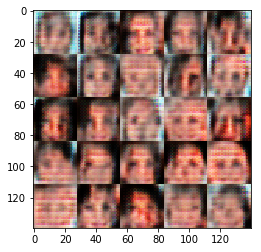

Epoch: 0 Gen Loss: 0.9021 Disc Loss: 1.2783
Epoch: 0 Gen Loss: 0.8166 Disc Loss: 1.5347
Epoch: 0 Gen Loss: 1.1071 Disc Loss: 1.1964
Epoch: 0 Gen Loss: 1.1826 Disc Loss: 1.1504
Epoch: 0 Gen Loss: 1.8652 Disc Loss: 0.8055
Epoch: 0 Gen Loss: 0.9528 Disc Loss: 1.6978
Epoch: 0 Gen Loss: 0.9150 Disc Loss: 1.3066
Epoch: 0 Gen Loss: 1.0222 Disc Loss: 1.1463
Epoch: 0 Gen Loss: 1.2150 Disc Loss: 1.0588
Epoch: 0 Gen Loss: 0.9949 Disc Loss: 1.2075


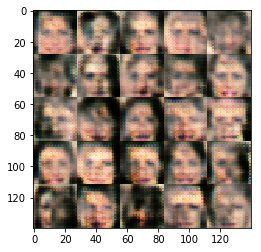

Epoch: 0 Gen Loss: 0.8253 Disc Loss: 1.3088
Epoch: 0 Gen Loss: 0.9751 Disc Loss: 1.1228
Epoch: 0 Gen Loss: 1.0353 Disc Loss: 1.1538
Epoch: 0 Gen Loss: 0.8247 Disc Loss: 1.6270
Epoch: 0 Gen Loss: 1.2546 Disc Loss: 1.1474
Epoch: 0 Gen Loss: 1.1778 Disc Loss: 1.1882
Epoch: 0 Gen Loss: 0.8079 Disc Loss: 1.3388
Epoch: 0 Gen Loss: 0.9532 Disc Loss: 1.1152
Epoch: 0 Gen Loss: 0.9671 Disc Loss: 1.2697
Epoch: 0 Gen Loss: 0.8124 Disc Loss: 1.4298


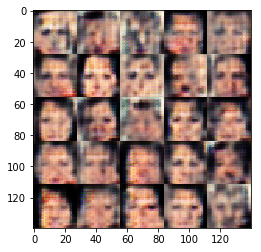

Epoch: 0 Gen Loss: 1.0195 Disc Loss: 1.0562
Epoch: 0 Gen Loss: 1.2696 Disc Loss: 0.9238
Epoch: 0 Gen Loss: 1.1287 Disc Loss: 1.2170
Epoch: 0 Gen Loss: 0.7513 Disc Loss: 1.7046
Epoch: 0 Gen Loss: 1.0823 Disc Loss: 1.2393
Epoch: 0 Gen Loss: 1.0293 Disc Loss: 1.2829
Epoch: 0 Gen Loss: 0.8754 Disc Loss: 1.3642
Epoch: 0 Gen Loss: 1.1045 Disc Loss: 1.1153
Epoch: 0 Gen Loss: 1.1107 Disc Loss: 1.1224
Epoch: 0 Gen Loss: 0.8316 Disc Loss: 1.4215


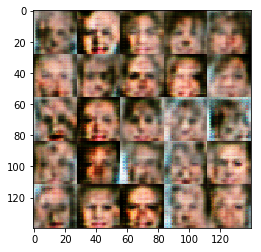

Epoch: 0 Gen Loss: 0.9787 Disc Loss: 1.2369
Epoch: 0 Gen Loss: 1.0368 Disc Loss: 1.1898
Epoch: 0 Gen Loss: 1.0338 Disc Loss: 1.3572
Epoch: 0 Gen Loss: 1.0300 Disc Loss: 1.3196
Epoch: 0 Gen Loss: 1.0192 Disc Loss: 1.1949
Epoch: 0 Gen Loss: 1.1077 Disc Loss: 1.1890
Epoch: 0 Gen Loss: 1.0385 Disc Loss: 1.1680
Epoch: 0 Gen Loss: 1.0696 Disc Loss: 1.1717
Epoch: 0 Gen Loss: 0.8049 Disc Loss: 1.4342
Epoch: 0 Gen Loss: 0.8810 Disc Loss: 1.2872


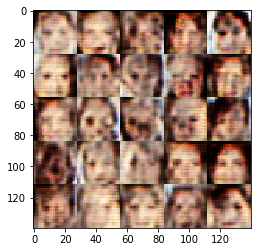

Epoch: 0 Gen Loss: 0.9468 Disc Loss: 1.2412
Epoch: 0 Gen Loss: 0.9553 Disc Loss: 1.1989
Epoch: 0 Gen Loss: 1.0925 Disc Loss: 1.1761
Epoch: 0 Gen Loss: 1.0615 Disc Loss: 1.1856
Epoch: 0 Gen Loss: 0.7255 Disc Loss: 1.7319
Epoch: 0 Gen Loss: 0.9210 Disc Loss: 1.3865
Epoch: 0 Gen Loss: 0.9440 Disc Loss: 1.2701
Epoch: 0 Gen Loss: 0.9747 Disc Loss: 1.2737
Epoch: 0 Gen Loss: 0.9572 Disc Loss: 1.2862
Epoch: 0 Gen Loss: 1.0476 Disc Loss: 1.1797


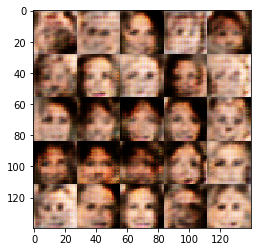

Epoch: 0 Gen Loss: 0.9684 Disc Loss: 1.2372
Epoch: 0 Gen Loss: 0.9411 Disc Loss: 1.2435
Epoch: 0 Gen Loss: 0.8453 Disc Loss: 1.3200
Epoch: 0 Gen Loss: 0.8491 Disc Loss: 1.2194
Epoch: 0 Gen Loss: 0.9158 Disc Loss: 1.1684
Epoch: 0 Gen Loss: 0.9707 Disc Loss: 1.1942
Epoch: 0 Gen Loss: 0.9388 Disc Loss: 1.3233
Epoch: 0 Gen Loss: 0.8610 Disc Loss: 1.4819
Epoch: 0 Gen Loss: 0.7843 Disc Loss: 1.4277
Epoch: 0 Gen Loss: 0.9310 Disc Loss: 1.3692


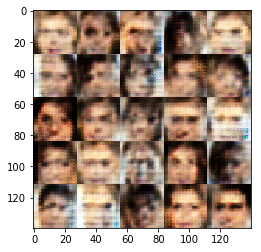

Epoch: 0 Gen Loss: 0.9371 Disc Loss: 1.2502
Epoch: 0 Gen Loss: 1.1755 Disc Loss: 1.2728
Epoch: 0 Gen Loss: 1.0965 Disc Loss: 1.3039
Epoch: 0 Gen Loss: 1.2076 Disc Loss: 1.1355
Epoch: 0 Gen Loss: 1.0090 Disc Loss: 1.2360
Epoch: 0 Gen Loss: 0.9172 Disc Loss: 1.3024
Epoch: 0 Gen Loss: 1.1507 Disc Loss: 1.1621
Epoch: 0 Gen Loss: 0.9253 Disc Loss: 1.4522
Epoch: 0 Gen Loss: 0.8937 Disc Loss: 1.3795
Epoch: 0 Gen Loss: 0.9295 Disc Loss: 1.2727


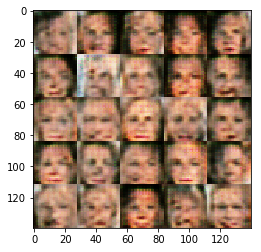

Epoch: 0 Gen Loss: 0.8236 Disc Loss: 1.3668
Epoch: 0 Gen Loss: 0.8148 Disc Loss: 1.2752
Epoch: 0 Gen Loss: 0.9220 Disc Loss: 1.1460
Epoch: 0 Gen Loss: 0.9061 Disc Loss: 1.1870
Epoch: 0 Gen Loss: 0.9166 Disc Loss: 1.3879
Epoch: 0 Gen Loss: 0.7998 Disc Loss: 1.4869
Epoch: 0 Gen Loss: 1.1744 Disc Loss: 1.0643
Epoch: 0 Gen Loss: 0.8914 Disc Loss: 1.5516
Epoch: 0 Gen Loss: 0.9592 Disc Loss: 1.2963
Epoch: 0 Gen Loss: 0.9059 Disc Loss: 1.2356


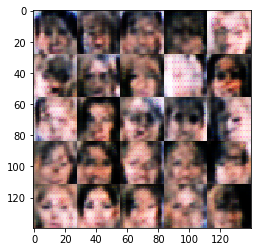

Epoch: 0 Gen Loss: 0.8757 Disc Loss: 1.3142
Epoch: 0 Gen Loss: 0.9388 Disc Loss: 1.2220
Epoch: 0 Gen Loss: 1.0363 Disc Loss: 1.1706
Epoch: 0 Gen Loss: 0.9883 Disc Loss: 1.3637
Epoch: 0 Gen Loss: 0.8960 Disc Loss: 1.4630
Epoch: 0 Gen Loss: 0.8643 Disc Loss: 1.2896
Epoch: 0 Gen Loss: 1.0705 Disc Loss: 1.1003
Epoch: 0 Gen Loss: 1.0614 Disc Loss: 1.1662
Epoch: 0 Gen Loss: 0.8269 Disc Loss: 1.3730
Epoch: 0 Gen Loss: 0.9395 Disc Loss: 1.2707


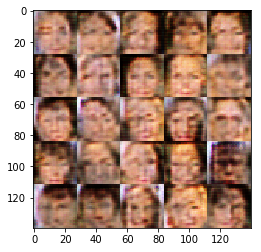

Epoch: 0 Gen Loss: 0.9197 Disc Loss: 1.3871
Epoch: 0 Gen Loss: 1.1137 Disc Loss: 1.0284
Epoch: 0 Gen Loss: 1.0587 Disc Loss: 1.1300
Epoch: 0 Gen Loss: 0.8411 Disc Loss: 1.4702
Epoch: 0 Gen Loss: 0.9785 Disc Loss: 1.2882
Epoch: 0 Gen Loss: 1.2597 Disc Loss: 0.9541
Epoch: 0 Gen Loss: 0.8455 Disc Loss: 1.5382
Epoch: 0 Gen Loss: 0.7529 Disc Loss: 1.5513
Epoch: 0 Gen Loss: 1.0854 Disc Loss: 1.1851
Epoch: 0 Gen Loss: 1.0527 Disc Loss: 1.1216


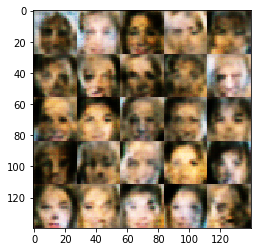

Epoch: 0 Gen Loss: 0.8828 Disc Loss: 1.2669
Epoch: 0 Gen Loss: 0.7588 Disc Loss: 1.5039
Epoch: 0 Gen Loss: 0.8325 Disc Loss: 1.3218
Epoch: 0 Gen Loss: 1.0077 Disc Loss: 1.1667
Epoch: 0 Gen Loss: 0.9024 Disc Loss: 1.4089
Epoch: 0 Gen Loss: 0.8016 Disc Loss: 1.4829
Epoch: 0 Gen Loss: 0.9454 Disc Loss: 1.2628
Epoch: 0 Gen Loss: 0.9347 Disc Loss: 1.1917
Epoch: 0 Gen Loss: 0.9473 Disc Loss: 1.2545
Epoch: 0 Gen Loss: 0.8451 Disc Loss: 1.3744


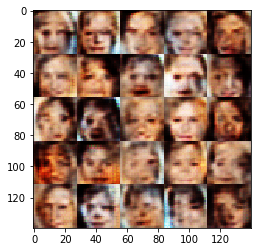

Epoch: 0 Gen Loss: 0.8460 Disc Loss: 1.4209
Epoch: 0 Gen Loss: 0.9372 Disc Loss: 1.2712
Epoch: 0 Gen Loss: 0.9236 Disc Loss: 1.2343
Epoch: 0 Gen Loss: 0.9154 Disc Loss: 1.2940
Epoch: 0 Gen Loss: 0.8189 Disc Loss: 1.4027
Epoch: 0 Gen Loss: 0.8023 Disc Loss: 1.4127
Epoch: 0 Gen Loss: 0.8592 Disc Loss: 1.3217
Epoch: 0 Gen Loss: 0.8738 Disc Loss: 1.3027
Epoch: 0 Gen Loss: 0.8163 Disc Loss: 1.3111
Epoch: 0 Gen Loss: 0.8467 Disc Loss: 1.3057


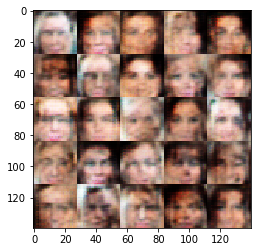

Epoch: 0 Gen Loss: 0.8412 Disc Loss: 1.2937
Epoch: 0 Gen Loss: 0.8923 Disc Loss: 1.2426
Epoch: 0 Gen Loss: 0.8007 Disc Loss: 1.3429
Epoch: 0 Gen Loss: 0.7566 Disc Loss: 1.3959
Epoch: 0 Gen Loss: 0.7775 Disc Loss: 1.4330
Epoch: 0 Gen Loss: 0.8272 Disc Loss: 1.2950
Epoch: 0 Gen Loss: 0.9373 Disc Loss: 1.2511
Epoch: 0 Gen Loss: 0.9031 Disc Loss: 1.2171
Epoch: 0 Gen Loss: 0.8390 Disc Loss: 1.3833
Epoch: 0 Gen Loss: 0.8885 Disc Loss: 1.3989


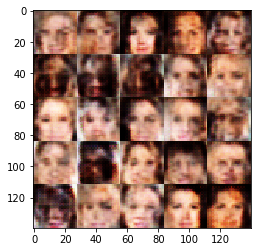

Epoch: 0 Gen Loss: 0.9007 Disc Loss: 1.4182
Epoch: 0 Gen Loss: 0.8557 Disc Loss: 1.3831
Epoch: 0 Gen Loss: 0.9937 Disc Loss: 1.2135
Epoch: 0 Gen Loss: 0.9843 Disc Loss: 1.2278
Epoch: 0 Gen Loss: 0.9937 Disc Loss: 1.2191
Epoch: 0 Gen Loss: 0.7959 Disc Loss: 1.4278
Epoch: 0 Gen Loss: 0.7620 Disc Loss: 1.4720
Epoch: 0 Gen Loss: 0.8625 Disc Loss: 1.2565
Epoch: 0 Gen Loss: 0.8500 Disc Loss: 1.2731
Epoch: 0 Gen Loss: 0.8053 Disc Loss: 1.2965


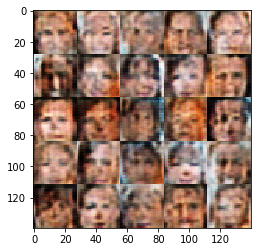

Epoch: 0 Gen Loss: 0.8108 Disc Loss: 1.2856
Epoch: 0 Gen Loss: 0.8717 Disc Loss: 1.3389
Epoch: 0 Gen Loss: 0.7709 Disc Loss: 1.4119
Epoch: 0 Gen Loss: 0.7771 Disc Loss: 1.3434
Epoch: 0 Gen Loss: 0.9139 Disc Loss: 1.1785
Epoch: 0 Gen Loss: 0.9211 Disc Loss: 1.2520
Epoch: 0 Gen Loss: 0.7368 Disc Loss: 1.5078
Epoch: 0 Gen Loss: 0.9434 Disc Loss: 1.2802
Epoch: 0 Gen Loss: 1.0659 Disc Loss: 1.1659
Epoch: 0 Gen Loss: 0.8848 Disc Loss: 1.4459


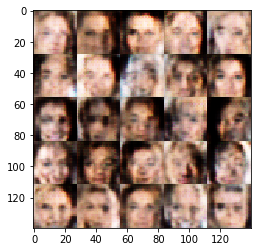

Epoch: 0 Gen Loss: 0.8323 Disc Loss: 1.3419
Epoch: 0 Gen Loss: 1.0086 Disc Loss: 1.1178
Epoch: 0 Gen Loss: 0.9668 Disc Loss: 1.2209
Epoch: 0 Gen Loss: 0.8264 Disc Loss: 1.5025
Epoch: 0 Gen Loss: 0.9049 Disc Loss: 1.2644
Epoch: 0 Gen Loss: 1.0573 Disc Loss: 1.1388
Epoch: 0 Gen Loss: 0.8518 Disc Loss: 1.4196
Epoch: 0 Gen Loss: 0.7272 Disc Loss: 1.4465
Epoch: 0 Gen Loss: 0.9979 Disc Loss: 1.1342
Epoch: 0 Gen Loss: 1.0505 Disc Loss: 1.1362


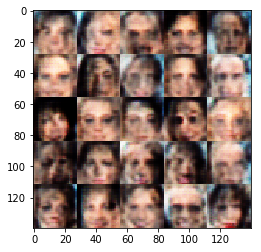

Epoch: 0 Gen Loss: 0.8627 Disc Loss: 1.4118
Epoch: 0 Gen Loss: 0.8815 Disc Loss: 1.3532
Epoch: 0 Gen Loss: 0.9587 Disc Loss: 1.2680
Epoch: 0 Gen Loss: 0.8179 Disc Loss: 1.3759
Epoch: 0 Gen Loss: 0.8024 Disc Loss: 1.3681
Epoch: 0 Gen Loss: 0.9521 Disc Loss: 1.2182
Epoch: 0 Gen Loss: 1.1111 Disc Loss: 1.1827
Epoch: 0 Gen Loss: 0.7453 Disc Loss: 1.5965
Epoch: 0 Gen Loss: 0.8875 Disc Loss: 1.3782
Epoch: 0 Gen Loss: 0.8906 Disc Loss: 1.2931


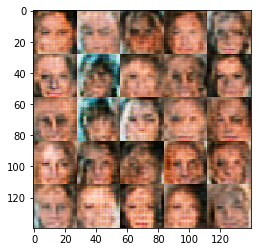

Epoch: 0 Gen Loss: 0.8460 Disc Loss: 1.3912
Epoch: 0 Gen Loss: 0.9158 Disc Loss: 1.1645
Epoch: 0 Gen Loss: 0.9109 Disc Loss: 1.1620
Epoch: 0 Gen Loss: 0.8364 Disc Loss: 1.3738
Epoch: 0 Gen Loss: 0.7254 Disc Loss: 1.5425
Epoch: 0 Gen Loss: 0.9411 Disc Loss: 1.3251
Epoch: 0 Gen Loss: 1.0228 Disc Loss: 1.2373
Epoch: 0 Gen Loss: 1.0061 Disc Loss: 1.2421
Epoch: 0 Gen Loss: 0.8646 Disc Loss: 1.3538
Epoch: 0 Gen Loss: 0.8645 Disc Loss: 1.2420


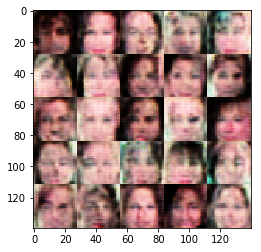

Epoch: 0 Gen Loss: 0.9165 Disc Loss: 1.2081
Epoch: 0 Gen Loss: 0.8312 Disc Loss: 1.3265
Epoch: 0 Gen Loss: 0.8171 Disc Loss: 1.3529
Epoch: 0 Gen Loss: 0.9521 Disc Loss: 1.1506
Epoch: 0 Gen Loss: 0.8727 Disc Loss: 1.2923
Epoch: 0 Gen Loss: 0.7727 Disc Loss: 1.5365
Epoch: 0 Gen Loss: 0.9724 Disc Loss: 1.2132
Epoch: 0 Gen Loss: 0.9368 Disc Loss: 1.1986
Epoch: 0 Gen Loss: 0.9341 Disc Loss: 1.4882
Epoch: 0 Gen Loss: 0.9302 Disc Loss: 1.3888


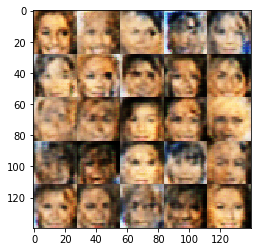

Epoch: 0 Gen Loss: 0.9302 Disc Loss: 1.3159
Epoch: 0 Gen Loss: 0.8154 Disc Loss: 1.3876
Epoch: 0 Gen Loss: 0.8637 Disc Loss: 1.2297
Epoch: 0 Gen Loss: 0.9723 Disc Loss: 1.1577
Epoch: 0 Gen Loss: 0.9429 Disc Loss: 1.2589
Epoch: 0 Gen Loss: 0.7841 Disc Loss: 1.5578


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.